In [2]:
from google.colab import drive
import os
if 'google.colab' in str(get_ipython()):
  drive.mount('/content/gdrive')
  os.chdir('/content/gdrive/MyDrive/Benchmarking-Distributional-Alignment-of-Small-Language-Models')

Mounted at /content/gdrive


In [2]:
import os
from google.colab import userdata
# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate for your system.
os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")

In [3]:
!pip install --upgrade -q transformers huggingface_hub peft \
  accelerate bitsandbytes datasets trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.6/447.6 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.9/310.9 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requ

In [9]:
from huggingface_hub import login
import tensorflow as tf
login(os.environ["HF_TOKEN"])
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [10]:
model_id = "google/gemma-2-2b-it"
device = "cuda"

In [11]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [12]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# Let's quantize the model to reduce its weight
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

# Let's load the final model
model = AutoModelForCausalLM.from_pretrained(
    model_id, device_map={"": 0}
)
model.gradient_checkpointing_enable()

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

In [9]:
sequence_zero_shot_prompt_text = """
Please simulate 30 samples from a group of Democrat for the question asked.
Please only respond with 30 multiple choice answers, no numbering, no new line, no extra spaces, characters, quotes or text. Please only produce 30 characters. Answers with more than 30 characters will not be accepted.

Given the `question`, produce the fields `answer`.

------

Question: Do you think the country's current economic conditions are helping or hurting people who are poor??
A. Helping a little. B. Helping a lot. C. Hurting a little. D. Hurting a lot. E. Neither helping nor hurting. F. Refused.
Answer:
"""

## Helper Functions


In [4]:
import numpy as np

def apply_chat_template(row):
  messages = [{"role": "user", "content": row["input"]}]
  nobos = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True)[1:]
  return tokenizer.decode(nobos)
def prepare_df(original_df):
  original_df["input"] = original_df.apply(apply_chat_template, axis=1)
  return original_df
def parse_answers(raw_response, available_choices):
    """
    Parse the answers from a raw response string and calculate counts and probabilities.

    Args:
        raw_response (str): The raw input string containing the answers.
        available_choices (list): A list of valid answer choices (e.g., ["A", "B", "C", "D", "E", "F"]).

    Returns:
        tuple: (status, result)
            - status (bool): True if successful, False if an error occurs.
            - result: A dictionary containing counts and probabilities if successful,
                      or an error message if an error occurs.
    """
    try:
        if "Answer:" not in raw_response:
            raise ValueError("No 'Answer:' keyword found in input.")
        answers_part = raw_response.split("Answer:")[1]
        answers_list = answers_part.strip().split()
        if not answers_list:
            raise ValueError("No parsable answers found in input.")
        counts = {choice: 0 for choice in available_choices}
        total_answers = 0

        for answer in answers_list:
            if answer in available_choices:
                counts[answer] += 1
                total_answers += 1
            else:
                # Skip invalid choices
                pass
        if total_answers == 0:
            raise ZeroDivisionError("No valid answers to calculate probabilities.")
        probabilities = {choice: count / total_answers for choice, count in counts.items()}
        return True, {"counts": counts, "probabilities": probabilities}

    except ValueError as ve:
        return False, {"message": str(ve)}
    except ZeroDivisionError as zde:
        return False, {"message": str(zde)}
    except Exception as e:
        return False, {"message": f"Unexpected error: {str(e)}"}

def calculate_kld(golden_distribution, predicted_distribution):
    golden_probs = np.array([golden_distribution[key] for key in golden_distribution])
    predicted_probs = np.array([predicted_distribution[key] for key in golden_distribution])
    epsilon = 1e-12
    golden_probs = np.clip(golden_probs, epsilon, 1)
    predicted_probs = np.clip(predicted_probs, epsilon, 1)
    kld = np.sum(golden_probs * np.log(golden_probs / predicted_probs))
    return kld

def calculate_jsd(golden_distribution, predicted_distribution):
    golden_probs = np.array([golden_distribution[key] for key in golden_distribution])
    predicted_probs = np.array([predicted_distribution[key] for key in golden_distribution])
    epsilon = 1e-12
    golden_probs = np.clip(golden_probs, epsilon, 1)
    predicted_probs = np.clip(predicted_probs, epsilon, 1)
    m = 0.5 * (golden_probs + predicted_probs)
    kl_golden_to_m = np.sum(golden_probs * np.log(golden_probs / m))
    kl_predicted_to_m = np.sum(predicted_probs * np.log(predicted_probs / m))
    jsd = 0.5 * (kl_golden_to_m + kl_predicted_to_m)
    return jsd

def compute_kld_values(golden_distribution, sampled_distributions):
    return [calculate_kld(golden_distribution, dist) for dist in sampled_distributions]

def compute_jsd_values(golden_distribution, sampled_distributions):
    return [calculate_jsd(golden_distribution, dist) for dist in sampled_distributions]

# Prompting Baseline

In [5]:
instruction = apply_chat_template({"input": sequence_zero_shot_prompt_text})
inputs = tokenizer(instruction, return_tensors="pt").to(device)
# Examine one example
outputs = model.generate(**inputs, max_new_tokens=90, do_sample=True,
    eos_token_id=tokenizer.eos_token_id, early_stopping=True)
response = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(response)

NameError: name 'sequence_zero_shot_prompt_text' is not defined

In [1]:
import random
available_choices = ["A", "B", "C", "D", "E", "F"]

k = 30
successful_parsings = 0
total_attempts = 0
probabilities_list = []
while successful_parsings < k:
  outputs = model.generate(
    **inputs,
    max_new_tokens=36,
    do_sample=True,
    eos_token_id=tokenizer.eos_token_id,
    early_stopping=True
  )
  response = tokenizer.decode(outputs[0], skip_special_tokens=True)
  success, result = parse_answers(response, available_choices)
  total_attempts += 1
  if success:
    successful_parsings += 1
    probabilities_list.append(result["probabilities"])
success_rate = successful_parsings / total_attempts
baseline_probabilities = probabilities_list

NameError: name 'model' is not defined

In [15]:
success_rate

0.8571428571428571

# Fine-tune and prompting the fine-tuned model

In [3]:
from utils import *
demographic_group = "POLPARTY"
demographic = "Democrat"
output_type = "model_logprobs"
rank = 1

qIDs, waves = get_q_IDs_opinionqa()
raw_dataset = get_few_shot_training_examples(
    qIDs[0],
    wave="Pew_American_Trends_Panel_disagreement_100",
    demographic_group=demographic_group,
    demographic=demographic,
    output_type=output_type,
    n_shots=5,
    n_simulations_per_shot=5,
)

training_dataset = prepare_df(raw_dataset.copy())
training_dataset.head(3)

UnboundLocalError: local variable 'prompt' referenced before assignment

In [15]:
training_dataset.input[0]

'<start_of_turn>user\nYour task is to simulate an answer to a new question from the group of Democrats. After the examples, please simulate an answer from a group of "Democrat" for the question asked. Please only respond with a single multiple choice answer, no extra spaces, characters, quotes or text. Please only produce 1 character. Answers with more than one characters will not be accepted.\nQuestion: How much, if at all, do you think some people work harder than others contributes to economic inequality in this country??\nA. Contributes a fair amount. B. Contributes a great deal. C. Contributes not at all. D. Contributes not too much. E. Refused.<end_of_turn>\n<start_of_turn>model\n'

In [20]:
from peft import LoraConfig
lora_config = LoraConfig(
    r=1,
    task_type="CAUSAL_LM",
    target_modules=[
        "q_proj",
        "o_proj",
        "k_proj",
        "v_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
)

In [21]:
import transformers
from datasets import Dataset
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example['input'])):
        text = f"{example['input'][i]}{example['output'][i]}"
        output_texts.append(text)
    return output_texts
# Create Trainer objects that takes care of the process
response_template = "Answer:"
hf_dataset = Dataset.from_pandas(training_dataset)
# To turn on train with output (completion only), follow https://huggingface.co/docs/trl/v0.7.1/en/sft_trainer#train-on-completions-only
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)
trainer = SFTTrainer(
    model=model,
    train_dataset=hf_dataset,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=2,
        max_steps=20,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=1,
        output_dir="outputs",
        optim="paged_adamw_8bit",
    ),
    peft_config=lora_config,
    data_collator=collator,
    formatting_func=formatting_prompts_func,
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:309: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/25 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:403: UserWarning: You passed a processing_class with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `processing_class.padding_side = 'right'` to your code.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


In [22]:
trainer.model.print_trainable_parameters()

trainable params: 1,297,920 || all params: 2,615,639,808 || trainable%: 0.0496


In [23]:
import torch
torch.cuda.empty_cache()
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
1,2.496700
2,2.637700
3,2.488200
4,1.802000
5,1.865200
6,1.764100
7,2.691700
8,1.497000
9,1.504100
10,1.495300


TrainOutput(global_step=20, training_loss=1.8667313873767852, metrics={'train_runtime': 65.6633, 'train_samples_per_second': 1.218, 'train_steps_per_second': 0.305, 'total_flos': 177753182257152.0, 'train_loss': 1.8667313873767852, 'epoch': 3.2})

In [24]:
instruction = apply_chat_template({"input": sequence_zero_shot_prompt_text})
inputs = tokenizer(instruction, return_tensors="pt").to(device)
# Examine one example
outputs = model.generate(**inputs, max_new_tokens=36, do_sample=True,
    eos_token_id=tokenizer.eos_token_id, early_stopping=True)
response = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(response)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:638: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


user
Please simulate 30 samples from a group of Democrat for the question asked.
Please only respond with 30 multiple choice answers, no numbering, no new line, no extra spaces, characters, quotes or text. Please only produce 30 characters. Answers with more than 30 characters will not be accepted.

Given the `question`, produce the fields `answer`.

------

Question: Do you think the country's current economic conditions are helping or hurting people who are poor??
A. Helping a little. B. Helping a lot. C. Hurting a little. D. Hurting a lot. E. Neither helping nor hurting. F. Refused.
Answer:
model
D C B A F E F B F D D F F D F F A D C D C C A C D D D D C D F D D A A C


In [26]:
import random
available_choices = ["A", "B", "C", "D", "E", "F"]
k = 30
successful_parsings = 0
total_attempts = 0
probabilities_list = []
while successful_parsings < k:
  outputs = model.generate(
    **inputs,
    max_new_tokens=36,
    do_sample=True,
    eos_token_id=tokenizer.eos_token_id,
    early_stopping=True
  )
  response = tokenizer.decode(outputs[0], skip_special_tokens=True)
  success, result = parse_answers(response, available_choices)
  print(response)
  total_attempts += 1
  if success:
    successful_parsings += 1
    probabilities_list.append(result["probabilities"])
success_rate = successful_parsings / total_attempts

user
Please simulate 30 samples from a group of Democrat for the question asked.
Please only respond with 30 multiple choice answers, no numbering, no new line, no extra spaces, characters, quotes or text. Please only produce 30 characters. Answers with more than 30 characters will not be accepted.

Given the `question`, produce the fields `answer`.

------

Question: Do you think the country's current economic conditions are helping or hurting people who are poor??
A. Helping a little. B. Helping a lot. C. Hurting a little. D. Hurting a lot. E. Neither helping nor hurting. F. Refused.
Answer:
model
C D C D E D D D D C D D D C E D D D D D D A D D D D G D D D D D A D D D
user
Please simulate 30 samples from a group of Democrat for the question asked.
Please only respond with 30 multiple choice answers, no numbering, no new line, no extra spaces, characters, quotes or text. Please only produce 30 characters. Answers with more than 30 characters will not be accepted.

Given the `question`

In [27]:
print(f"Success rate: {success_rate * 100:.2f}%")
print(f"Probabilities distributions for {k} successful parsings:")
for idx, probabilities in enumerate(probabilities_list):
    print(f"Parsing {idx + 1}: {probabilities}")

Success rate: 83.33%
Probabilities distributions for 30 successful parsings:
Parsing 1: {'A': 0.05714285714285714, 'B': 0.0, 'C': 0.11428571428571428, 'D': 0.7714285714285715, 'E': 0.05714285714285714, 'F': 0.0}
Parsing 2: {'A': 0.08333333333333333, 'B': 0.08333333333333333, 'C': 0.2222222222222222, 'D': 0.5277777777777778, 'E': 0.08333333333333333, 'F': 0.0}
Parsing 3: {'A': 0.25, 'B': 0.027777777777777776, 'C': 0.1388888888888889, 'D': 0.5, 'E': 0.05555555555555555, 'F': 0.027777777777777776}
Parsing 4: {'A': 0.027777777777777776, 'B': 0.08333333333333333, 'C': 0.3888888888888889, 'D': 0.4166666666666667, 'E': 0.08333333333333333, 'F': 0.0}
Parsing 5: {'A': 0.5277777777777778, 'B': 0.027777777777777776, 'C': 0.19444444444444445, 'D': 0.25, 'E': 0.0, 'F': 0.0}
Parsing 6: {'A': 0.1388888888888889, 'B': 0.027777777777777776, 'C': 0.2777777777777778, 'D': 0.3888888888888889, 'E': 0.16666666666666666, 'F': 0.0}
Parsing 7: {'A': 0.027777777777777776, 'B': 0.0, 'C': 0.08333333333333333, 'D'

In [28]:
golden_distribution = {'A': 0.06757843925985518, 'B': 0.02172164119066774, 'C': 0.12389380530973451, 'D': 0.7393403057119872, 'E': 0.0418342719227675, 'F': 0.0056315366049879325}
ft_model_jsd_values = compute_jsd_values(golden_distribution, probabilities_list)
baseline_model_jsd_values = compute_jsd_values(golden_distribution, baseline_probabilities)
print(f"JSD with averaged distribution fine-tuned model: {ft_model_jsd_values}")
print(f"JSD with averaged distribution baseline: {baseline_model_jsd_values}")

JSD with averaged distribution fine-tuned model: [0.010560075743539784, 0.03146160937796469, 0.04438409926688591, 0.07814896241833791, 0.18485134534638095, 0.07121634081281955, 0.035811493868966635, 0.10802843738583827, 0.08784473087833164, 0.09026467852101888, 0.04004521681173573, 0.040561880301219246, 0.13982330436832713, 0.026031859913617308, 0.08296291956040125, 0.0872442268057947, 0.09189316521001792, 0.12422596675661896, 0.10380448350986185, 0.011303679024563014, 0.038126829838127665, 0.058739770510641415, 0.03536023059629693, 0.6405783189622589, 0.20194503409368114, 0.12021701144772204, 0.10739917168801663, 0.16377087798816625, 0.6757395843258984, 0.086913878159282]
JSD with averaged distribution baseline: [0.19591956440889632, 0.2090899060450192, 0.1965662690323995, 0.20937826987315486, 0.2087404931844925, 0.22650250331056296, 0.3150763416472211, 0.2090899060450192, 0.20475922573403152, 0.20536302377118754, 0.2239781218902852, 0.1965662690323995, 0.2090899060450192, 0.247847677

In [29]:
import matplotlib.pyplot as plt

def plot_kld_comparison_box(model1_jsd_values, model2_jsd_values):
    data = [model1_jsd_values, model2_jsd_values]
    labels = ['Baseline Model', 'LORA Fine-tuned Model']
    means = [np.mean(jsd_values) for jsd_values in data]
    variances = [np.var(jsd_values) for jsd_values in data]
    plt.figure(figsize=(10, 6))
    plt.boxplot(data, labels=labels, patch_artist=True, showmeans=True)
    for i, (mean, variance) in enumerate(zip(means, variances), start=1):
        plt.text(i, plt.ylim()[1] * 0.9, f"Mean: {mean:.2f}", ha='center', fontsize=10, color='blue')
        plt.text(i, plt.ylim()[1] * 0.85, f"Var: {variance:.2f}", ha='center', fontsize=10, color='green')
    plt.title("Comparison of JSD Values Between Two Models")
    plt.ylabel("JSD Value")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

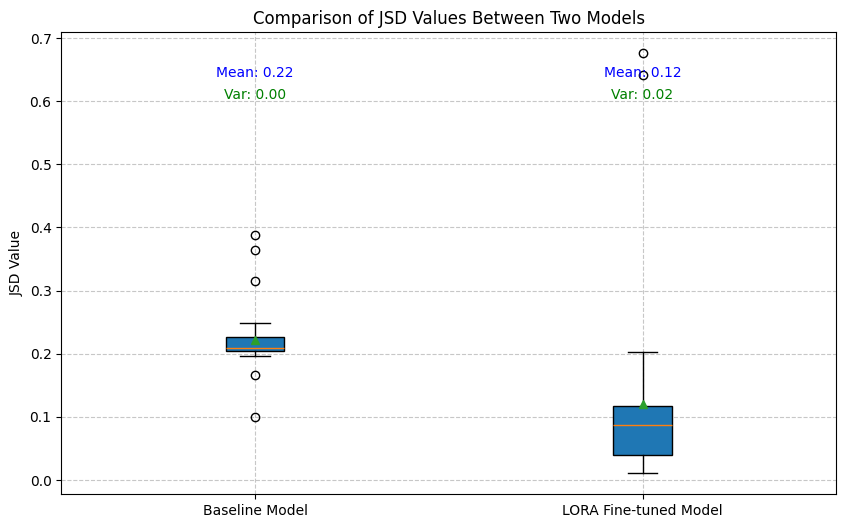

In [30]:
plot_kld_comparison_box(baseline_model_jsd_values, ft_model_jsd_values)

In [ ]:
model.push_to_hub("gemma-2-lora-finetuned-sequence" + demographic)